In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
NFFT = 8192 # Количество точек БПФ

## Банки фильтров
Последним шагом к вычислению банков фильтров является применение треугольных фильтров, обычно 40 фильтров, по шкале Мела, к спектру мощности для выделения частотных диапазонов. Шкала Мела направлена на то, чтобы имитировать нелинейное восприятие звука человеческим ухом, будучи более различимой на более низких частотах и менее различимой на более высоких частотах. Мы можем конвертировать между Герцами (f) и Mel (m), используя следующие уравнения:
$$m = 2595 \log_{10} \left(1+\frac{f}{700}\right), \quad\quad\quad(4)$$
$$f = 700 \left(10^{\frac{m}{2595}}-1\right).\quad\quad\quad(5)$$

Каждый фильтр в банке фильтров имеет треугольную форму с откликом 1 на центральной частоте и линейно уменьшается к 0, пока не достигнет центральных частот двух соседних фильтров, где отклик равен 0. Это можно смоделировать с помощью следующего уравнения: 
$$
H_m (k)=
\begin{cases}
   0, &\text{ $k<f(m-1)$},\\
   \frac{k-f(m-1)}{f(m)-f(m-1)}, &\text{ $f(m-1) \leq k < f(m)$},\\
   \frac{f(m+1)-k}{f(m+1)-f(m)}, &\text{ $f(m) \leq k \leq f(m+1)$},\\
   0, &\text{ $k > f(m+1)$}.
 \end{cases}
\quad\quad\quad(6)
$$
$f$ - список из $M+2$ меловых частот. 

In [3]:
nfilt = 40
low_freq_mel = (2595 * np.log10(1 + (44100 / NFFT) / 700))
high_freq_mel = (2595 * np.log10(1 + (44100 / 2) / 700))  # Конвертирование Гц в Мел
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Точки, равномерно расположенные по мел-шкале
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Конвертирование Мел в Гц
print(mel_points)
print(hz_points)
# У нас нет разрешения по частоте, необходимого для установки фильтров в точных точках, рассчитанных выше, 
# поэтому нам нужно округлить эти частоты до ближайшего бина БПФ. Этот процесс не влияет на точность признаков. 
# Чтобы преобразовать частоты в числа бинов БПФ, нам нужно знать размер БПФ и частоту дискретизации.
bin = np.floor((NFFT + 1) * hz_points / 44100)
print(bin)

# Мы можем видеть, что окончательный банк фильтров заканчивается на бине 1024, 
# что соответствует 10 кГц с размером БПФ в 2048 точек.

 
fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))

for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # левая сторона
    f_m = int(bin[m])             # центр
    f_m_plus = int(bin[m + 1])    # правая сторона
 
    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
fbank1 = [f[0] for f in fbank.T]


[   8.63391264  104.1144836   199.59505455  295.07562551  390.55619646
  486.03676741  581.51733837  676.99790932  772.47848027  867.95905123
  963.43962218 1058.92019313 1154.40076409 1249.88133504 1345.36190599
 1440.84247695 1536.3230479  1631.80361885 1727.28418981 1822.76476076
 1918.24533172 2013.72590267 2109.20647362 2204.68704458 2300.16761553
 2395.64818648 2491.12875744 2586.60932839 2682.08989934 2777.5704703
 2873.05104125 2968.5316122  3064.01218316 3159.49275411 3254.97332507
 3350.45389602 3445.93446697 3541.41503793 3636.89560888 3732.37617983
 3827.85675079 3923.33732174]
[5.38330078e+00 6.77489449e+01 1.35628575e+02 2.09509704e+02
 2.89922946e+02 3.77445832e+02 4.72706952e+02 5.76390474e+02
 6.89241053e+02 8.12069185e+02 9.45757023e+02 1.09126472e+03
 1.24963730e+03 1.42201222e+03 1.60962746e+03 1.81383049e+03
 2.03608788e+03 2.27799591e+03 2.54129196e+03 2.82786702e+03
 3.13977928e+03 3.47926890e+03 3.84877409e+03 4.25094867e+03
 4.68868103e+03 5.16511500e+03 5.6836

Text(0.5, 1.0, 'The full filterbank')

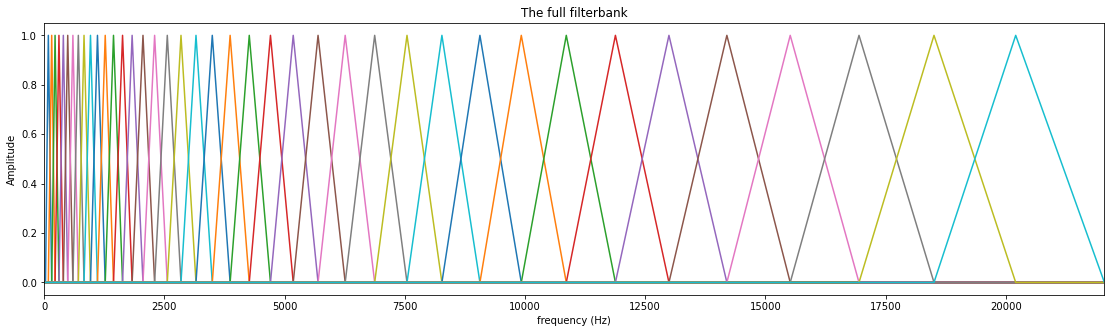

In [4]:
fig, ax = plt.subplots(1, figsize=(19, 5))
freq = np.linspace(44100/2048,44100/2,int(np.floor(NFFT / 2 + 1)))
ax.plot(freq, fbank.T)
ax.set_xlim([0, 44100/2])
plt.xlabel('frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('The full filterbank')

In [5]:
with open('filters.npy', 'wb') as f:
    np.save(f, fbank)

_________________________

In [6]:
low_freq = 440 * (2**(1/12))**(-36)
high_freq = 440 * (2**(1/12))**48            
low_freq_mel = (2595 * np.log10(1 + low_freq / 700))
high_freq_mel = (2595 * np.log10(1 + high_freq / 700))  # Конвертирование Гц в Мел
hz_points = np.array([440 * (2**(1/12))**n for n in range(-36,49)])
mel_points = (2595 * np.log10(1 + hz_points) / 700)  # Конвертирование Гц в Мел
print(mel_points)
print(hz_points)
# У нас нет разрешения по частоте, необходимого для установки фильтров в точных точках, рассчитанных выше, 
# поэтому нам нужно округлить эти частоты до ближайшего бина БПФ. Этот процесс не влияет на точность признаков. 
# Чтобы преобразовать частоты в числа бинов БПФ, нам нужно знать размер БПФ и частоту дискретизации.
b = np.floor((NFFT + 1) * hz_points / 44100)
print(b)
print(len(b))

[ 6.48078276  6.57216511  6.66363659  6.75519234  6.84682779  6.93853859
  7.03032062  7.12216999  7.214083    7.30605618  7.3980862   7.49016995
  7.58230447  7.67448696  7.76671477  7.85898541  7.9512965   8.0436458
  8.13603121  8.22845071  8.32090243  8.41338456  8.50589543  8.59843344
  8.69099707  8.78358491  8.8761956   8.96882788  9.06148054  9.15415244
  9.24684252  9.33954976  9.4322732   9.52501193  9.61776511  9.71053193
  9.80331163  9.89610348  9.98890681 10.08172097 10.17454537 10.26737942
 10.36022258 10.45307436 10.54593426 10.63880183 10.73167665 10.8245583
 10.9174464  11.0103406  11.10324055 11.19614592 11.28905642 11.38197176
 11.47489166 11.56781588 11.66074416 11.75367629 11.84661204 11.93955121
 12.03249361 12.12543907 12.2183874  12.31133845 12.40429206 12.49724809
 12.59020641 12.68316689 12.7761294  12.86909384 12.96206008 13.05502804
 13.14799762 13.24096872 13.33394127 13.42691517 13.51989035 13.61286675
 13.70584429 13.79882291 13.89180254 13.98478314 14.0

In [7]:
nfilt = 83

 
fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))

for m in range(1, nfilt + 1):
    f_m_minus = int(b[m - 1])   # левая сторона
    f_m = int(b[m])             # центр
    f_m_plus = int(b[m + 1])    # правая сторона
 
    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - b[m - 1]) / (b[m] - b[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (b[m + 1] - k) / (b[m + 1] - b[m])
fbank1 = [f[82] for f in fbank.T]

In [8]:
fbank.T.shape # количество отсчетов в каждом фильтре банка равно np.floor(NFFT / 2 + 1)

(4097, 83)

Text(0.5, 1.0, 'The full filterbank')

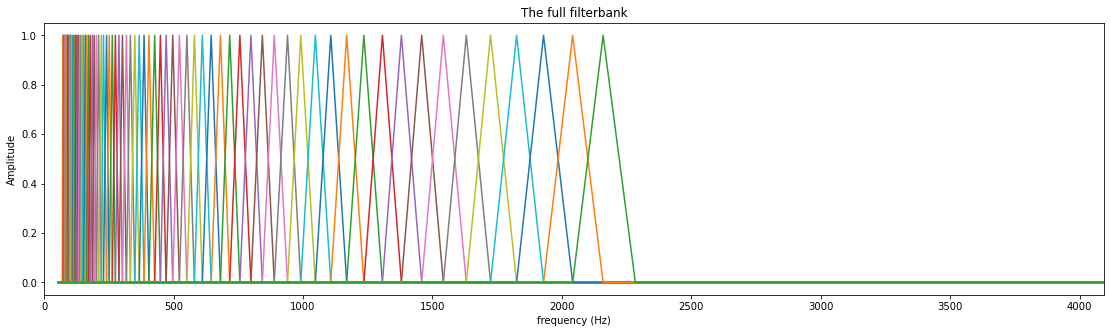

In [9]:
fig, ax = plt.subplots(1, figsize=(19, 5))
freq = np.linspace(low_freq ,high_freq,int(np.floor(NFFT / 2 + 1)))
ax.plot(freq, fbank.T)
ax.set_xlim([0, NFFT/2])
plt.xlabel('frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('The full filterbank')

In [10]:
with open('filters_1.npy', 'wb') as f:
    np.save(f, fbank)